In [1]:
] add Images ImageIO ImageFiltering Plots FITSIO ImageShow StatsBase

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [2]:
using Images, ImageIO

In [3]:
load("sdss-camera.jpg")

In [4]:
using FITSIO

In [5]:
rfile = FITS("frame-r-000752-5-0408.fits")

File: frame-r-000752-5-0408.fits
Mode: "r" (read-only)
HDUs: Num  Name  Type   
      1          Image  
      2          Image  
      3          Table  
      4          Table  

In [7]:
read_header(rfile[1]);

In [8]:
rimage = read(rfile[1])
size(rimage), typeof(rimage)

((2048, 1489), Array{Float32,2})

In [9]:
Gray.(rimage)

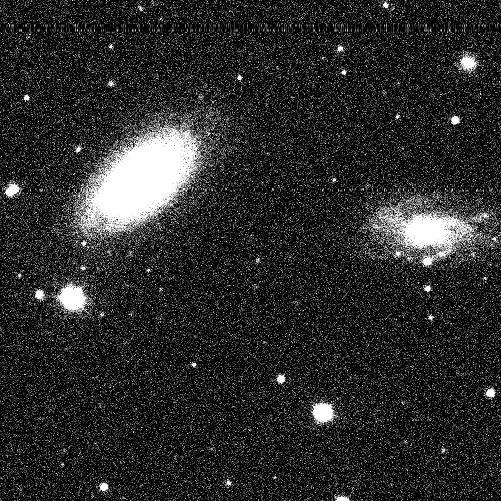

In [12]:
rsub = rimage[1000:1500, 500:1000];
Gray.(rsub * 10)

In [11]:
size(rsub)

(501, 501)

In [13]:
using Plots

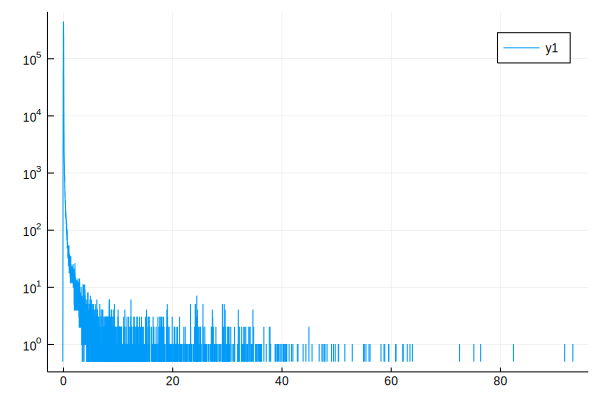

In [16]:
histogram(vec(rimage), yscale=:log10)

In [17]:
using Statistics

In [18]:
lo,mid,hi = quantile(vec(rimage), [0.16, 0.5, 0.84])

3-element Array{Float64,1}:
 -0.020599365234375
  0.00262451171875 
  0.029998779296875

In [21]:
histogram(vec(rimage), bins=range(-0.1, 1, length=50), yscale=:log10)

In [23]:
gfile = FITS("frame-g-000752-5-0408.fits")
ifile = FITS("frame-i-000752-5-0408.fits")
gimage = read(gfile[1])
iimage = read(ifile[1]);

2-element Array{Array{Gray{Float32},2},1}:
 [Gray{Float32}(0.008178711f0) Gray{Float32}(0.01550293f0) … Gray{Float32}(-0.00630188f0) Gray{Float32}(-0.009963989f0); Gray{Float32}(-0.013839722f0) Gray{Float32}(-0.010177612f0) … Gray{Float32}(0.015716553f0) Gray{Float32}(-0.028320312f0); … ; Gray{Float32}(-0.010467529f0) Gray{Float32}(-0.0031356812f0) … Gray{Float32}(-0.024932861f0) Gray{Float32}(-0.0065994263f0); Gray{Float32}(0.00053215027f0) Gray{Float32}(0.015213013f0) … Gray{Float32}(-0.013931274f0) Gray{Float32}(-0.0029296875f0)]
 [Gray{Float32}(0.006614685f0) Gray{Float32}(-0.07006836f0) … Gray{Float32}(0.03741455f0) Gray{Float32}(0.005470276f0); Gray{Float32}(0.03857422f0) Gray{Float32}(-0.018951416f0) … Gray{Float32}(-0.00730896f0) Gray{Float32}(-0.05206299f0); … ; Gray{Float32}(-0.019042969f0) Gray{Float32}(0.10852051f0) … Gray{Float32}(0.037231445f0) Gray{Float32}(-0.013793945f0); Gray{Float32}(0.006477356f0) Gray{Float32}(-0.0637207f0) … Gray{Float32}(-0.026550293f0) Gray{Float32}(0.024475098f0)]
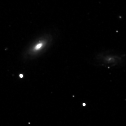
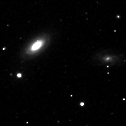

In [25]:
gsub = gimage[1000:1500, 500:1000];
isub = iimage[1000:1500, 500:1000];
[Gray.(gsub), Gray.(isub)]

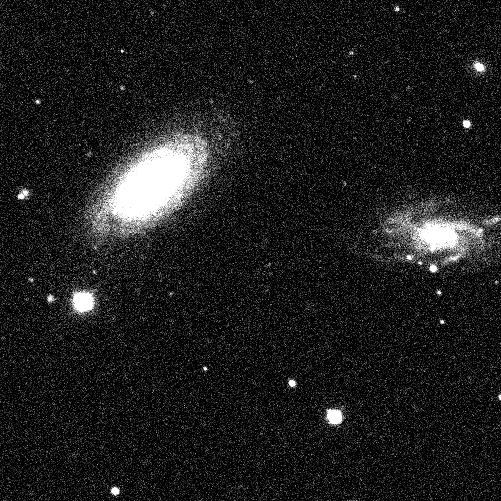

In [29]:
Gray.(gsub * 10)

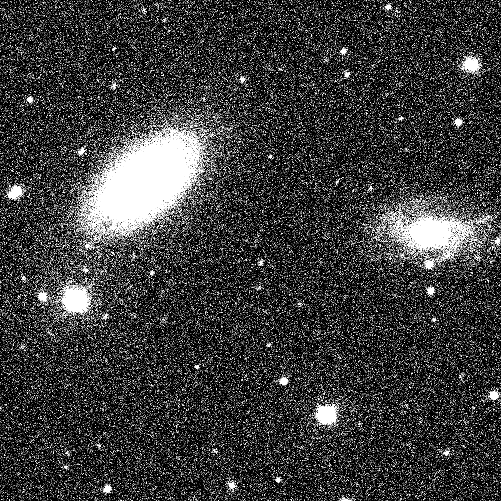

In [30]:
Gray.(isub * 10)

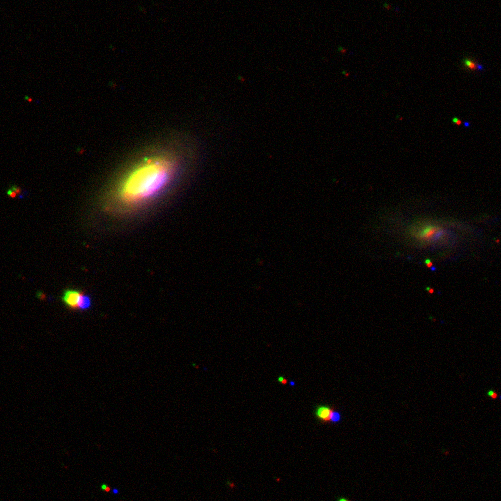

In [31]:
colorview(RGB, isub, rsub, gsub)

In [32]:
# psf_fwhm = 1.3"
# 1.3 / 0.396 = 3.3 pixels FWHM / 2.35 = 1.4 pixels Gaussian sigma

In [33]:
using ImageFiltering

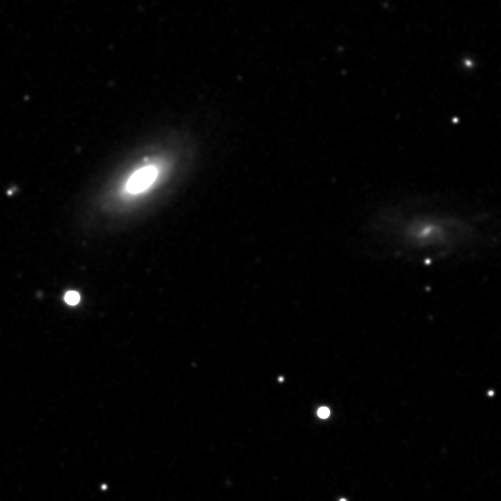

In [35]:
sigma = 1.4
gauss_kernel = Kernel.gaussian(sigma)
rfilt = imfilter(rsub, gauss_kernel)
Gray.(rfilt)

In [36]:
lo,mid,hi = quantile(vec(rimage), [0.16, 0.5, 0.84])
rsigma = mid - lo


0.023223876953125

In [39]:
rfilt_sigma = rsigma / (2. * sqrt(pi) * sigma)

0.004679524809481404

In [37]:
lo,mid,hi = quantile(vec(rfilt), [0.16, 0.5, 0.84])
mid - lo

0.0059138566169876

In [42]:
function find_peaks(filt, filt_sigma, nsigma)
    H,W = size(filt)
    peak_x = []
    peak_y = []
    for i = 2:H-1
        for j = 2:W-1
            if ((filt[i, j] > filt_sigma * nsigma) &&
                (filt[i, j] > filt[i-1, j]) &&
                (filt[i, j] > filt[i-1, j-1]) &&
                (filt[i, j] > filt[i-1, j+1]) &&
                (filt[i, j] > filt[i+1, j]) &&
                (filt[i, j] > filt[i+1, j-1]) &&
                (filt[i, j] > filt[i+1, j+1]) &&
                (filt[i, j] > filt[i  , j-1]) &&
                (filt[i, j] > filt[i  , j+1]) )
                append!(peak_x, j)
                append!(peak_y, i)
            end
        end
    end
    peak_x, peak_y
end

find_peaks (generic function with 1 method)

In [45]:
nsigma = 8
rx,ry = find_peaks(rfilt, rfilt_sigma, nsigma)
length(rx)

136

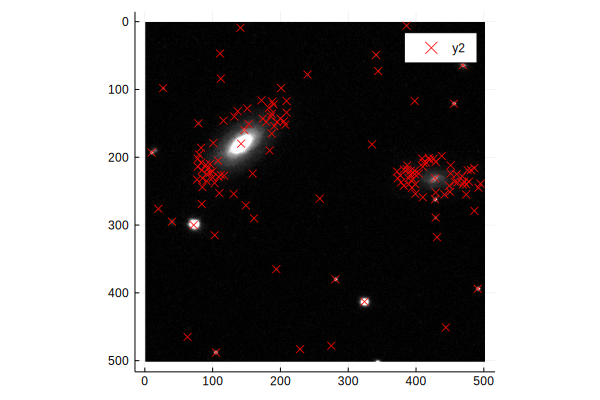

In [47]:
plot(1. * Gray.(rsub))
plot!(rx, ry, seriestype=:scatter, markershape=:x, color="red")

In [49]:
lo,mid,hi = quantile(vec(gimage), [0.16, 0.5, 0.84])
gsigma = mid - lo
lo,mid,hi = quantile(vec(iimage), [0.16, 0.5, 0.84])
isigma = mid - lo
gfilt_sigma = gsigma / (2. * sqrt(pi) * sigma)
ifilt_sigma = isigma / (2. * sqrt(pi) * sigma)
gfilt = imfilter(gsub, gauss_kernel)
ifilt = imfilter(isub, gauss_kernel)
gx,gy = find_peaks(gfilt, gfilt_sigma, nsigma)
ix,iy = find_peaks(ifilt, ifilt_sigma, nsigma)
plot(10. * Gray.(gsub))
plot!(gx, gy, seriestype=:scatter, markershape=:x, color="red")


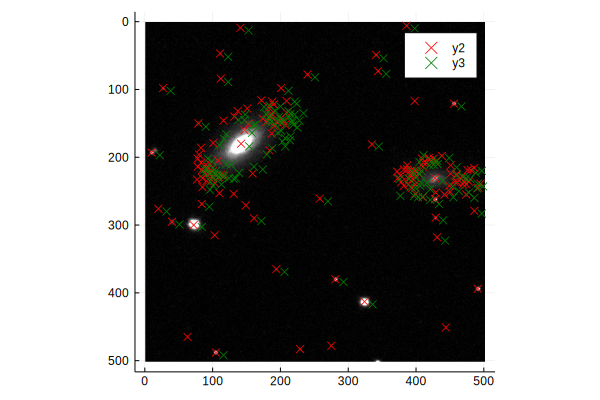

In [50]:
plot(1. * Gray.(rsub))
plot!(rx, ry, seriestype=:scatter, markershape=:x, color="red")
plot!(gx, gy, seriestype=:scatter, markershape=:x, color="green")

In [51]:
plot(10. * Gray.(isub))
plot!(ix, iy, seriestype=:scatter, markershape=:x, color="red")

In [53]:
function find_nearby(x1,y1,  x2,y2, dist)
    I = []
    J = []
    for i in 1:length(x1)
        for j in 1:length(x2)
            if hypot(x1[i] - x2[j], y1[i] - y2[j]) < dist
                append!(I, i)
                append!(J, j)
            end
        end
    end
    I,J
end

find_nearby (generic function with 1 method)

In [54]:
I,J = find_nearby(rx,ry, gx,gy, 50.)

(Any[1, 2, 2, 3, 3, 4, 4, 5, 6, 6  …  126, 126, 127, 127, 127, 128, 129, 131, 131, 136], Any[1, 2, 3, 3, 8, 4, 6, 5, 4, 6  …  130, 136, 129, 133, 137, 138, 139, 139, 140, 141])

In [63]:
dx = rx[I] - gx[J]
dy = ry[I] - gy[J];

In [66]:
plot(dx, dy, seriestype=:scatter, alpha=0.1)

In [67]:
histogram2d(dx, dy, bins=20)

In [68]:
using StatsBase

In [87]:
function find_most_common(dx, dy)
    H = fit(Histogram, (dx, dy), (minimum(dx):maximum(dx), minimum(dy):maximum(dy)))
    a = argmax(H.weights)
    ax,ay = a.I
    xe,ye = H.edges
    xe[ax], ye[ay]
end

find_most_common (generic function with 1 method)

In [88]:
shiftx,shifty = find_most_common(dx, dy)

(-11, -4)

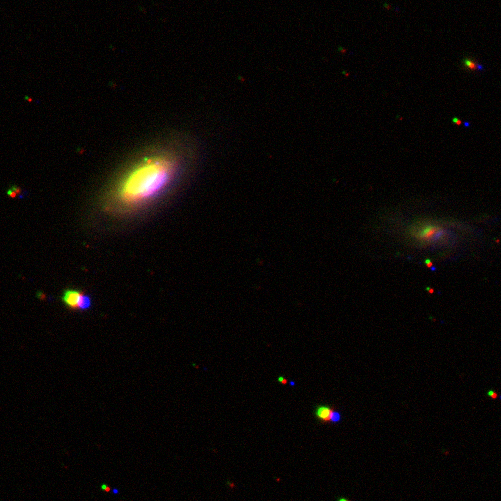

In [89]:
colorview(RGB, isub, rsub, gsub)

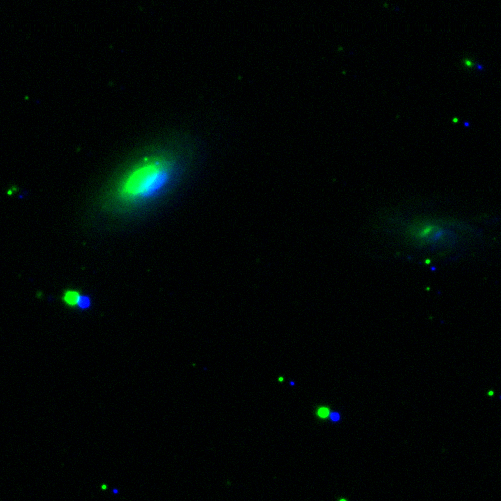

In [90]:
H,W = size(rsub)
zsub = zeros(H,W)
colorview(RGB, zsub, rsub, gsub)

In [99]:
padding = 20
H,W = size(rsub)

padr = zeros((H + 2*padding, W + 2*padding))
padr[padding+1 : padding+H, padding+1 : padding+W] = rsub;

padg = zeros((H + 2*padding, W + 2*padding))
padg[shifty + padding+1 : shifty + padding+H, shiftx + padding+1 : shiftx + padding+W] = gsub;

padi = zeros((H + 2*padding, W + 2*padding));


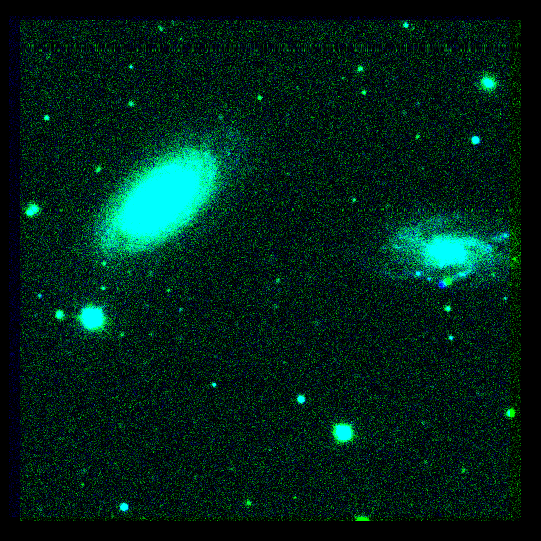

In [102]:
colorview(RGB, 10 .* padi, 10 .* padr, 10 .* padg)

In [103]:
I,J = find_nearby(rx,ry, ix,iy, 50.)
dx = rx[I]-ix[J]
dy = ry[I]-iy[J]
six,siy = find_most_common(dx,dy)
padi[siy + padding+1 : siy + padding+H, six + padding+1 : six + padding+W] = isub;

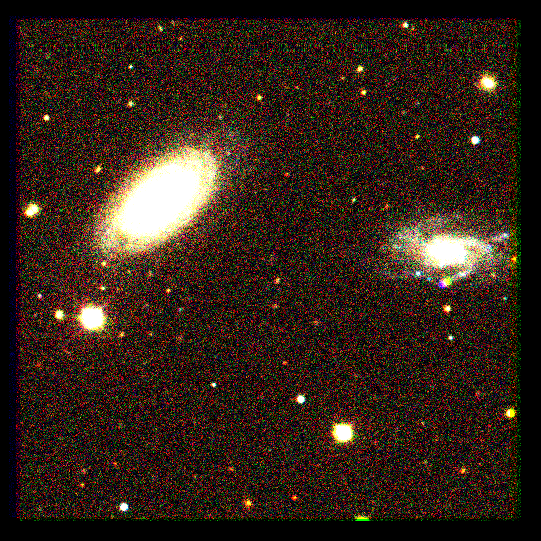

In [104]:
colorview(RGB, 10 .* padi, 10 .* padr, 10 .* padg)

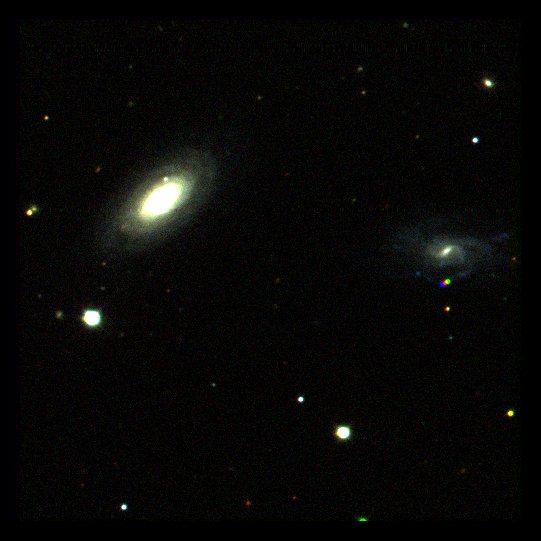

In [105]:
colorview(RGB, 1 .* padi, 1.5 .* padr, 2. .* padg)

In [107]:
colorview(RGB,
    sqrt.(clamp.(1   .* padi, 0, 1)),
    sqrt.(clamp.(1.5 .* padr, 0, 1)),
    sqrt.(clamp.(2.  .* padg, 0, 1)))